## MultiHead Attention Architecture


*   어텐션은 **세가지 요소**를 입력받는다.
  * **쿼리**
  * **키**
  * **값**
  * 현재 구현에서는 쿼리 키 값의 차원이 모두 같다

*   하이퍼 파라미터
  * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
  * **n_heads**: 헤드의 개수 = scaled dot= product attention의 개수
  * dropout_ratio: 드랍아웃 비율



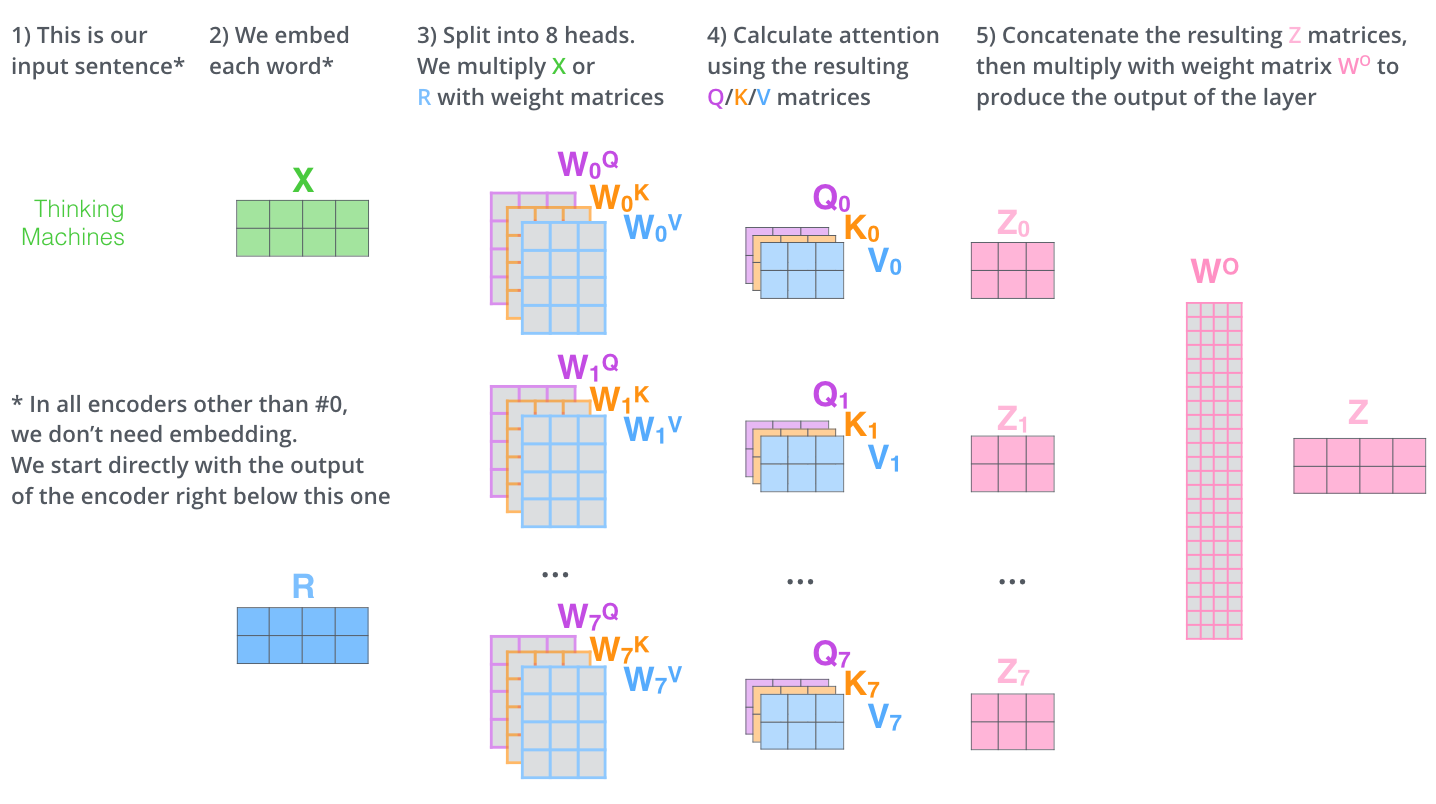

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
%%capture
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

In [ ]:
import torchtext
import torch
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab, vocab
from torchtext.utils import download_from_url, extract_archive
import io

url_base = 'https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/'
train_urls = ('train.de.gz', 'train.en.gz')
val_urls = ('val.de.gz', 'val.en.gz')
test_urls = ('test_2016_flickr.de.gz', 'test_2016_flickr.en.gz')

train_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in train_urls]
val_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in val_urls]
test_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in test_urls]

de_tokenizer = get_tokenizer('spacy', language='de_core_news_sm')
en_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

def build_vocab(filepath, tokenizer):
  counter = Counter()
  with io.open(filepath, encoding="utf8") as f:
    for string_ in f:
      counter.update(tokenizer(string_))
  return vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

de_vocab = build_vocab(train_filepaths[0], de_tokenizer)
en_vocab = build_vocab(train_filepaths[1], en_tokenizer)

def data_process(filepaths):
  raw_de_iter = iter(io.open(filepaths[0], encoding="utf8"))
  raw_en_iter = iter(io.open(filepaths[1], encoding="utf8"))
  data = []
  for (raw_de, raw_en) in zip(raw_de_iter, raw_en_iter):
    de_tensor_ = torch.tensor([de_vocab[token] if token in de_vocab else de_vocab['<unk>'] for token in de_tokenizer(raw_de.rstrip())],
                            dtype=torch.long)
    en_tensor_ = torch.tensor([en_vocab[token] if token in en_vocab else en_vocab['<unk>'] for token in en_tokenizer(raw_en.rstrip())],
                            dtype=torch.long)
    data.append((de_tensor_, en_tensor_))
  return data

train_data = data_process(train_filepaths)
val_data = data_process(val_filepaths)
test_data = data_process(test_filepaths)

BATCH_SIZE = 128
PAD_IDX = de_vocab['<pad>']
BOS_IDX = de_vocab['<bos>']
EOS_IDX = de_vocab['<eos>']

from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def generate_batch(data_batch):
  de_batch, en_batch = [], []
  for (de_item, en_item) in data_batch:
    de_batch.append(torch.cat([torch.tensor([BOS_IDX]), de_item, torch.tensor([EOS_IDX])], dim=0))
    en_batch.append(torch.cat([torch.tensor([BOS_IDX]), en_item, torch.tensor([EOS_IDX])], dim=0))
  de_batch = pad_sequence(de_batch, padding_value=PAD_IDX)
  en_batch = pad_sequence(en_batch, padding_value=PAD_IDX)
  return de_batch, en_batch

train_iter = DataLoader(train_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(val_data, batch_size=BATCH_SIZE,
                        shuffle=True, collate_fn=generate_batch)
test_iter = DataLoader(test_data, batch_size=BATCH_SIZE,
                       shuffle=True, collate_fn=generate_batch)

100%|██████████| 637k/637k [00:00<00:00, 72.6MB/s]
100%|██████████| 569k/569k [00:00<00:00, 23.8MB/s]
100%|██████████| 24.7k/24.7k [00:00<00:00, 9.62MB/s]
100%|██████████| 21.6k/21.6k [00:00<00:00, 9.44MB/s]
100%|██████████| 22.9k/22.9k [00:00<00:00, 8.46MB/s]
100%|██████████| 21.1k/21.1k [00:00<00:00, 9.27MB/s]


In [ ]:
import torch.nn as nn

class MultiHeadAttentionLayer(nn.Module):
  def __init__(self, hidden_dim, n_heads, dropout_ratio, device):
    super().__init__()

    assert hidden_dim % n_heads == 0

    self.hidden_dim = hidden_dim #임베딩 차원
    self.n_heads = n_heads # 헤드의 개수, 서로 다른 어텐션 컨셉의 수
    self.head_dim = hidden_dim // n_heads # 각 헤드에서의 임베딩 차원

    self.fc_q = nn.Linear(hidden_dim, hidden_dim) # Query값에 적용될 FC레이어
    self.fc_k = nn.Linear(hidden_dim, hidden_dim) # Key값에 적용될 FC레이어
    self.fc_v = nn.Linear(hidden_dim, hidden_dim) # Value값에 적용될 FC레이어

    self.fc_o = nn.Linear(hidden_dim, hidden_dim)

    self.dropout = nn.Dropout(dropout_ratio)

    self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device) #scaled 에 해당

  def forward(self, query, key, value, mask = None):

    batch_size = query.shape[0]
    #batch_size = 32

    # query : [batch_size, query_len, hidden_dim] 배치 사이즈, 쿼리 길이(단어 개수), 단어 임베딩 크기
    # key : [batch_size, key_len, hidden_dim]
    # value : [batch_size, value_len, hidden_dim]

    Q = self.fc_q(query)
    K = self.fc_k(key)
    V = self.fc_v(value)

    # Q : [batch_size, query_len, hidden_dim] 배치 사이즈, 쿼리 길이(단어 개수), 단어 임베딩 크기
    # K : [batch_size, key_len, hidden_dim]
    # V : [batch_size, value_len, hidden_dim]

    # hidden_dim → n_heads X head_dim 형태로 변형
    # n_heads(h)개의 서로 다른 어텐션(attention) 컨셉을 학습하도록 유도
    Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
    K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
    V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

    #각 헤드마다 쿼리와 키를 곱하고 스케일로 나눠준다 Attention energy 계산 (softmax안 식)
    energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
    # energy : [batch_size, n_heads, query_len, key_len]

    #마스크를 사용하는 경우
    if mask is not None:
      # 마스크 값이 0인 부분을 -1e10으로 채우기
      energy = energy.masked_fill(mask==0, -1e10) #fillna와 비슷

    # 어텐션 스코어 계산 : 각 단어에 대한 확률값
    attention = torch.softmax(energy, dim=-1) #마지막 차원 기준

    # attention: [batch_size, n_heads, query_len, key_len]

    # 여기에서 Scaled Dot Product Attention을 계산, V값과 곱함, attention value matrix 생성
    x = torch.matmul(self.dropout(attention), V)

    # x: [batch_size, n_heads, query_len, head_dim]
    
    x = x.permute(0,2,1,3).contiguous() #텐서의 shape을 조작하는 과정에서 메모리 저장 상태가 변경되는 경우 다시 돌리기 위함

    # x: [batch_size, query_len, n_heads, head_dim]
   
    x = x.view(batch_size, -1, self.hidden_dim) # concat

    # x: [batch_size, query_len, head_dim]
    
    x = self.fc_o(x) #output linear함수를 거친다.

    return x, attention


## Positon-wise Feedforward 아키텍처

* 입력과 출력의 차원이 동일합니다.
* 하이퍼 파라미터
  * hidden_dim : 한 단어에 대한 임베딩 차원
  * pf_dim: Feedforward 레이어에서의 내부 임베딩 차원
  * dropout_ratio : 드롭아웃 비율

  

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
  def __init__(self, hidden_dim, pf_dim, dropout_ratio):
    super().__init__()

    self.fc_1 = nn.Linear(hidden_dim, pf_dim)
    self.fc_2 = nn.Linear(pf_dim, hidden_dim)

    self.dropout = nn.Dropout(dropout_ratio)

  def forward(self,x):
    
    # x: [batch_size, seq_len, hidden_dim]

    x = self.dropout(torch.relu(self.fc_1(x)))


    # x: [batch_size, seq_len, pf_dim]

    x = self.fc_2(x)

    # x: [batch_size, seq_len, hidden_dim]

    return x



## 인코더 레이어 아키텍처
* 하나의 인코더레이어에 대해 정의
  * 입력과 출력의 차원이 같음
  * 이러한 특징을 이용해 트랜스포머의 인코더는 인코더레이어를 여러번 중첩해서 사용한다

* 하이퍼파라미터
  * hidden_dim: 하나의 단어에 대한 임베딩 차원
  * n_heads: 헤드의 개수
  * pf_dim: Feedforward 레이어에서의 내부 임베딩 차원
  * dropout_ratio

 * <pad> 토큰에 대하여 마스크 값을 0으로 설정 

In [ ]:
class EncoderLayer(nn.Module):
  def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
    super().__init__()

    self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
    self.ff_layer_norm = nn.LayerNorm(hidden_dim)
    self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
    self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
    self.dropout = nn.Dropout(dropout_ratio)


    # 하나의 임베딩이 복제되어 Q, K, V로 입력되는 방식
  def forward(self, src, src_mask):

    # src : [batch_size, src_len, hidden_dim]
    # src_mask : [batch_size, src_len]


    # self attention
    # 필요한 경우 마스크 행렬을 이용해서 어텐션할 단어를 조정

    _src, _ = self.self_attention(src, src, src, src_mask) # forward kwargs

    # dropout, residual connection and layer norm
    src = self.self_attn_layer_norm(src + self.dropout(_src))


    # src: [batch_size, src_len, hidden_dim]

    # position-wise feedforward

    _src = self.positionwise_feedforward(src)

    # dropout, residual and layernorm

    src = self.ff_layer_norm(src + self.dropout(_src))

    # src: [batch_size, src_len, hidden_dim]
 
    return src


## 인코더 아키텍처

* 전체 인코더 아키텍처 정의
* 하이퍼 파라미터
  * input_dim: 하나의 단어에 대한 원 핫 인코딩 차원
  * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
  * n_layers: 내부적으로 사용할 인코더 레이어의 개수
  * **n_heads**: 헤드의 개수 = scaled dot= product attention의 개수
  * pf_dim: Feedforward 레이어에서의 내부 임베딩 차원
  * dropout_ratio: 드랍아웃 비율
  * max_length: 문장내 최대 단어 개수
* 원본 논문과 다르게 positional encoding을 학습하는 형태로 구현
* \<pad\> 토큰에 대하여 마스크 값을 0으로 설정

In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
    super().__init__()

    self.device = device

    self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
    self.pos_embedding = nn.Embedding(max_length, hidden_dim) #포지셔널임베딩 학습

    self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

    self.dropout = nn.Dropout(dropout_ratio)

    self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

  def forward(self, src, src_mask):

    # src:[batchsize, src_len]
    # src_mask:[batchsize, src_len]

    batch_size = src.shape[0]
    src_len = src.shape[1]
    pos = torch.arange(0,src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

    # pos: [batch_size, src_len] [0, 1, 2 ... , src_len-1] X batch_size

    # 소스 문장의 임베딩과 위치 임베딩을 더한 것을 사용
    src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

    #src : [batch_size, src_len, hidden_dim]

    # 모든 인코더 레이러를 차례대로 거치면서 순전파(forward) 진행

    for layer in self.layers:
      src = layer(src, src_mask)

    # src : [batch_size, src_len, hidden_dim]

    return src # 마지막 레이어의 출력을 반환 



In [ ]:
import torch

In [ ]:
pos = torch.arange(0,2).unsqueeze(0).repeat(8 ,1)

In [ ]:
pos

tensor([[0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1]])

In [ ]:
torch.arange(0,6,2).unsqueeze(0)

tensor([[0, 2, 4]])

## 디코더 레이어 아키텍쳐

* 하나의 디코더 레이어에 대해 정의
  * 입력과 출력 차원이 같다
  * 이러한 특징을 이용해 디코더 레이어를 여러번 중첩
  * 디코더 레이어에서는 두개의 Multi-Head Attention 레이어가 사용됨

* 하이퍼파라미터
  * hidden_dim: 하나의 단어에 대한 임베딩 차원
  * n_heads: 헤드의 개수
  * pf_dim: Feedforward 레이어에서의 내부 임베딩 차원
  * dropout_ratio

 * <pad> 토큰에 대하여 마스크 값을 0으로 설정 
 * 타겟 문장에서 각 단어는 다음단어가 무엇인지 알 수 없도록 (이전 단어만 보도록 ) 만들기 위해 마스크를 사용

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim) 
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)  # 셀프 어텐션
        self.encoder_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device) # 인코더 디코더 어텐션
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    # 인코더의 출력 값(enc_src)을 어텐션(attention)하는 구조
    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len, hidden_dim]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        # self attention
        # 자기 자신에 대하여 어텐션(attention)
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        # dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # encoder attention
        # 디코더의 쿼리(Query)를 이용해 인코더를 어텐션(attention)
        # 쿼리는 디코더의 출력 단어 trg, 키와 밸류로 src를 이용
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return trg, attention
     

## 디코더 아키텍처

* 전체 인코더 아키텍처 정의
* 하이퍼 파라미터
  * input_dim: 하나의 단어에 대한 원 핫 인코딩 차원
  * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
  * n_layers: 내부적으로 사용할 인코더 레이어의 개수
  * **n_heads**: 헤드의 개수 = scaled dot= product attention의 개수
  * pf_dim: Feedforward 레이어에서의 내부 임베딩 차원
  * dropout_ratio: 드랍아웃 비율
  * max_length: 문장내 최대 단어 개수
* 원본 논문과 다르게 positional encoding을 학습하는 형태로 구현
* \<pad\> 토큰에 대하여 마스크 값을 0으로 설정

* Seq2Seq과는 마찬가지로 실제로 추론(inference) 시기에서는 디코더를 반복적으로 넣을 필요가 있습니다.
  * 학습(training) 시기에서는 한 번에 출력 문장을 구해 학습할 수 있습니다.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.fc_out = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, trg_len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

        # trg: [batch_size, trg_len, hidden_dim]

        for layer in self.layers:
            # 소스 마스크와 타겟 마스크 모두 사용
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        output = self.fc_out(trg)

        # output: [batch_size, trg_len, output_dim]

        return output, attention


## 트랜스포머 아키텍쳐

* 최종적인 전체 트랜스포머 모델을 정의
* 입력이 들어 왔을 때 앞서 정의한 인코더와 디코더를 거쳐 출력 문장 생성

In [ ]:
class Transformer(nn.Module):
  def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
    super().__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.src_pad_idx = src_pad_idx
    self.trg_pad_idx = trg_pad_idx
    self.device = device

  # 소스 문장의 <pad> 토큰에 대하여 마스크 값을 0으로 설정
  def make_src_mask(self, src):
    #src: [batch_size, src_len]

    src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
    
    # src_mask : [batch_size, 1, 1, src_len]

    return src_mask

  # 타겟 문장에서 각단어는 다음단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크 사용
  def make_trg_mask(self, trg):

    # trg: [batch_size, trg_len]

    """
    (패딩 마스크 예시)
    1 0 0 0 0
    1 1 0 0 0
    1 1 1 0 0
    1 1 1 0 0
    1 1 1 0 0
    """
    trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2).cuda()


    # trg_pad_ mask : [batch_size, 1, 1, trg_len]

    trg_len = trg.shape[1]

    """
    (sub mask 예시)
    1 0 0 0 0
    1 1 0 0 0
    1 1 1 0 0 
    1 1 1 1 0
    1 1 1 1 1
    """

    trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool().cuda()

    # trg_sub_mask = [trg_len, trg_len]

    trg_mask = trg_pad_mask & trg_sub_mask # 둘 중 하나라도 0 이면 마스킹

    # trg_mask: [batch_size, 1, trg_len, trg_len]

    return trg_mask

  def forward(self, src, trg):

    # src : [batch_size, src_len]
    # trg : [batch_size, trg_len]

    src_mask = self.make_src_mask(src)
    trg_mask = self.make_trg_mask(trg)


    # src_mask: [batch_size, 1, 1, src_len]
    # trg_mask: [batch_size, 1, trg_len, trg_len]

    
    enc_src = self.encoder(src, src_mask)

    # enc_src:[batch_size, src_len, hidden_dim]

    output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

    #output : [batch_size, trg_len, output_dim]
    #attention : [batch_size, n_heads, trg_len, src_len]

    return output, attention


## 학습

* 하이퍼파라미터 설정 및 모델 초기화


In [ ]:
INPUT_DIM = len(de_vocab)
OUTPUT_DIM = len(de_vocab)
HIDDEN_DIM =256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [ ]:
SRC_PAD_IDX = de_vocab['<pad>']
TRG_PAD_IDX = en_vocab['<pad>']

# 인코더(encoder)와 디코더(decoder) 객체 선언
enc = Encoder(INPUT_DIM, HIDDEN_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, HIDDEN_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)

# Transformer 객체 선언
model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
     

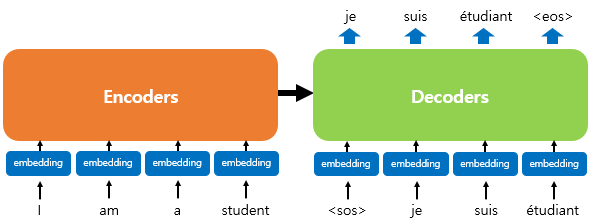

* 모델 가중치 파라미터 초기화

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


The model has 18,781,199 trainable parameters


In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(19215, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )


* 학습 및 평가 함수 정의

In [ ]:
import torch.optim as optim

# Adam optimizer로 최적화
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 뒷 부분의 패딩 에 대해서는 값 무시

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

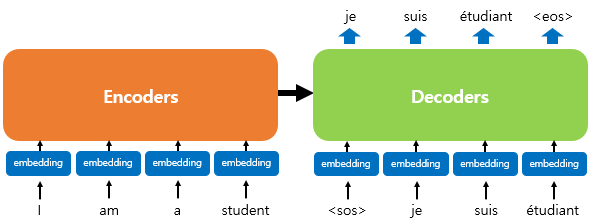

In [ ]:
# 모델 학습 함수
def train(model, iterator, optimizer, criterion, clip):
  model.train()#학습 모드
  epoch_loss =0

  #전체 학습 데이터를 확인하며
  for i, (src, trg) in enumerate(iterator):
    src = src.T.to(device)
    trg = trg.T.to(device)


    optimizer.zero_grad()

    # 출력 단어의 마지막 인덱스(<eos>)제외
    # 입력할 떄는 <sos>부터 시작하도록 처리
    output, _ = model(src, trg[:,:-1])


    #output : [배치크기, trg_len-1, output_dim]
    #trg : [배치 크기, trg_len]

    output_dim = output.shape[-1]

    output = output.contiguous().view(-1, output_dim)
    # 출력단어의 인덱스 0 (<sos>)는 제외
    trg = trg[:,1:].contiguous().view(-1)

    #output : [배치 크기 * trg_len-1, output_dim]
    #trg : [배치 크기 * trg_len-1]

    #모델의 출력 결과와 타겟 문장을 비교해서 손실 계산
    loss = criterion(output, trg)
    loss.backward() #기울기 계산

    # 기울기 clipping 진행
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

    #파라미터 업데이트
    optimizer.step()

    # 전체 손실값 계산
    epoch_loss += loss.item()

  return epoch_loss / len(iterator)


In [ ]:
for i, (src, trg) in enumerate(train_iter):
  src = src.T.to(device)
  trg = trg.T.to(device)

  break

trg

tensor([[   2,    4,  665,  ...,    1,    1,    1],
        [   2,    4,   17,  ...,    1,    1,    1],
        [   2, 1075,   76,  ...,    1,    1,    1],
        ...,
        [   2,    4,    5,  ...,    1,    1,    1],
        [   2,  171,   28,  ...,    1,    1,    1],
        [   2,  397,   17,  ...,    1,    1,    1]], device='cuda:0')

In [ ]:
trg[1].shape

torch.Size([32])

In [ ]:
trg[:,:-1].shape

torch.Size([128, 31])

In [ ]:
# 모델 평가(evaluate) 함수
def evaluate(model, iterator, criterion):
    model.eval() # 평가 모드
    epoch_loss = 0

    with torch.no_grad():
        # 전체 평가 데이터를 확인하며
        for i, (src, trg) in enumerate(iterator):
            src = src.T.to(device)
            trg = trg.T.to(device)

            # 출력 단어의 마지막 인덱스(<eos>)는 제외
            # 입력을 할 때는 <sos>부터 시작하도록 처리
            output, _ = model(src, trg[:,:-1])


            # output: [배치 크기, trg_len - 1, output_dim]
            # trg: [배치 크기, trg_len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            # 출력 단어의 인덱스 0(<sos>)은 제외
            trg = trg[:,1:].contiguous().view(-1)

            # output: [배치 크기 * trg_len - 1, output_dim]
            # trg: [배치 크기 * trg len - 1]

            # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
            loss = criterion(output, trg)

            # 전체 손실 값 계산
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
import math
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import time
import math
import random

N_EPOCHS = 10
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time() # 시작 시간 기록

    train_loss = train(model, train_iter, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iter, criterion)

    end_time = time.time() # 종료 시간 기록
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer_german_to_english.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')

Epoch: 01 | Time: 0m 29s
	Train Loss: 4.614 | Train PPL: 100.887
	Validation Loss: 3.365 | Validation PPL: 28.929
Epoch: 02 | Time: 0m 23s
	Train Loss: 2.946 | Train PPL: 19.027
	Validation Loss: 2.611 | Validation PPL: 13.612
Epoch: 03 | Time: 0m 24s
	Train Loss: 2.300 | Train PPL: 9.970
	Validation Loss: 2.282 | Validation PPL: 9.797
Epoch: 04 | Time: 0m 23s
	Train Loss: 1.899 | Train PPL: 6.677
	Validation Loss: 2.132 | Validation PPL: 8.435
Epoch: 05 | Time: 0m 23s
	Train Loss: 1.605 | Train PPL: 4.980
	Validation Loss: 2.045 | Validation PPL: 7.730
Epoch: 06 | Time: 0m 23s
	Train Loss: 1.379 | Train PPL: 3.972
	Validation Loss: 2.004 | Validation PPL: 7.416
Epoch: 07 | Time: 0m 24s
	Train Loss: 1.189 | Train PPL: 3.284
	Validation Loss: 1.988 | Validation PPL: 7.300
Epoch: 08 | Time: 0m 23s
	Train Loss: 1.034 | Train PPL: 2.813
	Validation Loss: 2.020 | Validation PPL: 7.535
Epoch: 09 | Time: 0m 23s
	Train Loss: 0.900 | Train PPL: 2.458
	Validation Loss: 2.041 | Validation PPL: 7.

In [ ]:
# 학습된 모델 저장
from google.colab import files

files.download('transformer_german_to_english.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.load_state_dict(torch.load("/content/transformer_german_to_english.pt"))
test_loss = evaluate(model, test_iter, criterion)

print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}')

Test Loss: 1.994 | Test PPL: 7.348


In [ ]:
import spacy

In [ ]:
# 번역(translation) 함수
def translate_sentence(sentence, de_vocab, en_vocab, model, device, max_len=50, logging=True):
    model.eval() # 평가 모드

    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    # 처음에 <sos> 토큰, 마지막에 <eos> 토큰 붙이기
    tokens = ['<bos>'] + tokens + ['<eos>']
    if logging:
        print(f"전체 소스 토큰: {tokens}")

    src_indexes = [de_vocab[token] if token in de_vocab else de_vocab['<unk>'] for token in tokens]
    if logging:
        print(f"소스 문장 인덱스: {src_indexes}")

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    # 소스 문장에 따른 마스크 생성
    src_mask = model.make_src_mask(src_tensor)

    # 인코더(endocer)에 소스 문장을 넣어 출력 값 구하기
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    # 처음에는 <sos> 토큰 하나만 가지고 있도록 하기
    trg_indexes = [en_vocab['<bos>']]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        # 출력 문장에 따른 마스크 생성
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        # 출력 문장에서 가장 마지막 단어만 사용
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token) # 출력 문장에 더하기

        # <eos>를 만나는 순간 끝
        if pred_token == en_vocab['<eos>']:
            break

    # 각 출력 단어 인덱스를 실제 단어로 변환
    trg_tokens = [en_vocab.get_itos()[i] for i in trg_indexes]

    # <sos>와 <eos>는 제외하고 출력 문장 반환
    return trg_tokens[1:-2], attention

In [ ]:
test_src = iter(io.open(test_filepaths[0], encoding="utf8"))
test_trg = iter(io.open(test_filepaths[1], encoding="utf8"))
for i in range(10):
  src = next(test_src).rstrip()
  trg = next(test_trg).rstrip()

  print(f'소스 문장: {src}')
  print(f'타겟 문장: {trg}')

  translation, attention = translate_sentence(src, de_vocab, en_vocab, model, device, logging=True)

  print("모델 출력 결과:", " ".join(translation))

  print("--------------------------------")

소스 문장: Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.
타겟 문장: A man in an orange hat starring at something.
전체 소스 토큰: ['<bos>', 'ein', 'mann', 'mit', 'einem', 'orangefarbenen', 'hut', ',', 'der', 'etwas', 'anstarrt', '.', '<eos>']
소스 문장 인덱스: [2, 22, 0, 19, 32, 102, 0, 52, 12, 188, 0, 16, 3]
모델 출력 결과: A muddy plane with an orange wagon
--------------------------------
소스 문장: Ein Boston Terrier läuft über saftig-grünes Gras vor einem weißen Zaun.
타겟 문장: A Boston Terrier is running on lush green grass in front of a white fence.
전체 소스 토큰: ['<bos>', 'ein', 'boston', 'terrier', 'läuft', 'über', 'saftig-grünes', 'gras', 'vor', 'einem', 'weißen', 'zaun', '.', '<eos>']
소스 문장 인덱스: [2, 22, 0, 0, 168, 273, 0, 0, 117, 32, 278, 0, 16, 3]
모델 출력 결과: A white fair is walking across a white tunnel with a white stuffed animal
--------------------------------
소스 문장: Ein Mädchen in einem Karateanzug bricht ein Brett mit einem Tritt.
타겟 문장: A girl in karate uniform breaking a stick with a front ki